In [2]:
import __init__

import glob
import os
import warnings
import numpy as np;
 
import skimage.io as io
from skimage import morphology
from skimage import feature
from skimage import measure
from skimage import segmentation
from skimage.transform import resize
from skimage import filters
from skimage import img_as_ubyte

import matplotlib as plt

import cfg
import imtools
import diagnostics
import segmentations
import cell_morphology
import annotations

%matplotlib inline 

# PARAMETERS

In [3]:
param=cfg.param() 
output_dir=param.getOutDir('output')
diag_dir=param.getOutDir('diag')
vis_diag=True

# INPUT

In [4]:
imDirs=os.listdir(param.getImageDirs())
print(imDirs)
image_dir=param.getImageDirs(dir_name=imDirs[-1])
included_extenstions = ['*.jpg', '*.bmp', '*.png', '*.gif']
image_list_indir = []
for ext in included_extenstions:
   image_list_indir.extend(glob.glob(os.path.join(image_dir, ext)))

for i, image_file in enumerate(image_list_indir):
    print(str(i)+' : '+image_file)

['Basophil', 'Eosinophil', 'Lymphocyte', 'Monocyte', 'Neutrophil', 'Problem']
0 : .\data\Test\WBC Types\Problem\99_EO.jpg
1 : .\data\Test\WBC Types\Problem\100_K32.bmp
2 : .\data\Test\WBC Types\Problem\103_K32.bmp
3 : .\data\Test\WBC Types\Problem\105_K32.bmp
4 : .\data\Test\WBC Types\Problem\11_17_gepi_5_8_13.bmp
5 : .\data\Test\WBC Types\Problem\11_K32.bmp
6 : .\data\Test\WBC Types\Problem\13_LY.bmp
7 : .\data\Test\WBC Types\Problem\14_17_gepi_5_8_13.bmp
8 : .\data\Test\WBC Types\Problem\159_K32.bmp
9 : .\data\Test\WBC Types\Problem\15_11_gepi_5_8_13.bmp
10 : .\data\Test\WBC Types\Problem\17_9_gepi_5_5_10.bmp
11 : .\data\Test\WBC Types\Problem\17_LY.bmp
12 : .\data\Test\WBC Types\Problem\1_10223_251_2350.bmp
13 : .\data\Test\WBC Types\Problem\208_K32.bmp
14 : .\data\Test\WBC Types\Problem\24_11_gepi_5_8_13.bmp
15 : .\data\Test\WBC Types\Problem\29_11_gepi_5_8_13.bmp
16 : .\data\Test\WBC Types\Problem\2_10061_237_2450.bmp
17 : .\data\Test\WBC Types\Problem\36_NE.bmp
18 : .\data\Test\W

In [5]:
image_file=image_list_indir[2]
print(image_file)

.\data\Test\WBC Types\Problem\103_K32.bmp


In [6]:
#image_file=r"d:\DATA\DiagonAdatbazis_20170221-5\Kenet32\95.bmp"

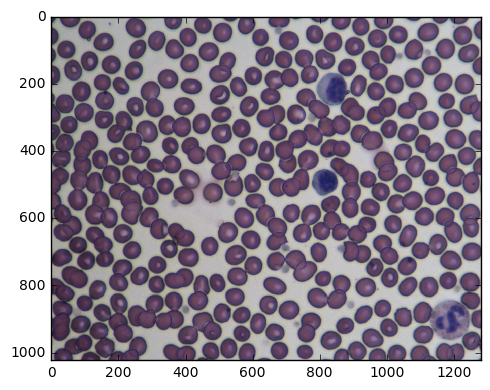

In [7]:
im = io.imread(image_file) # read uint8 image
io.imshow(im)

# DIAGNOSTICS

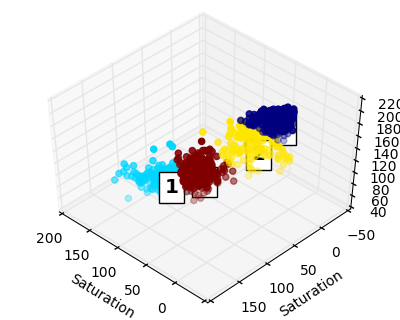

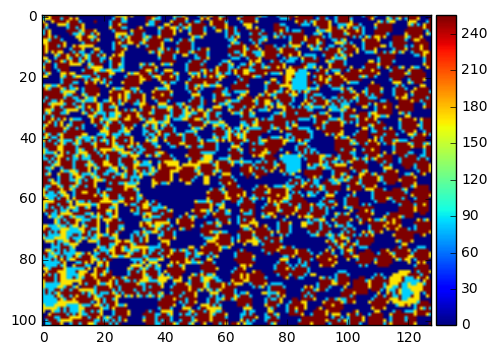

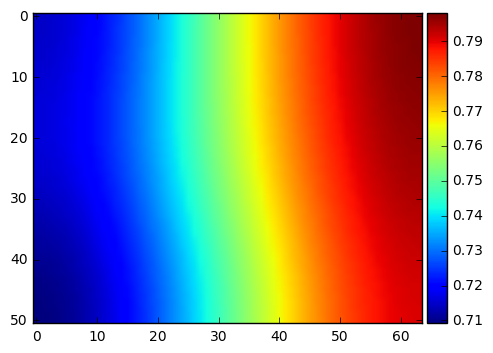

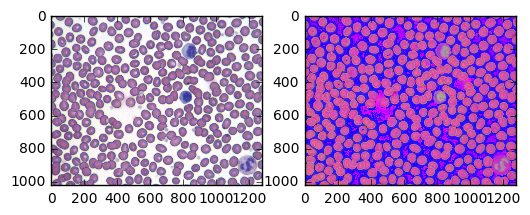

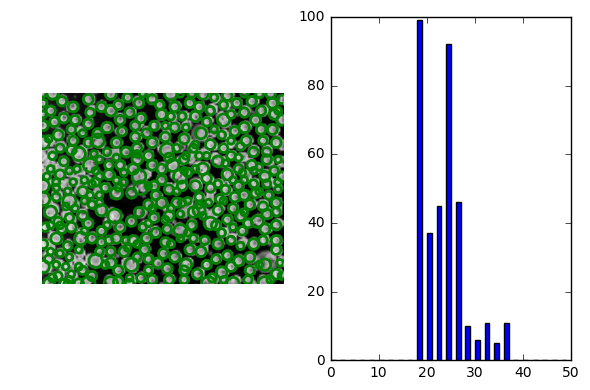

Error list:


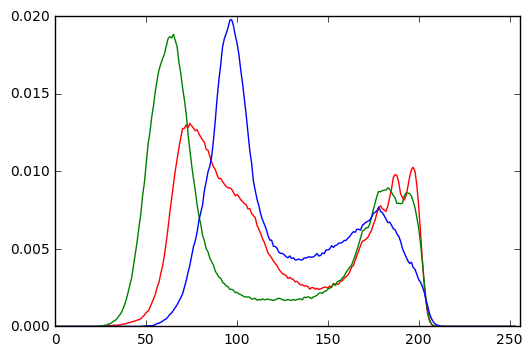

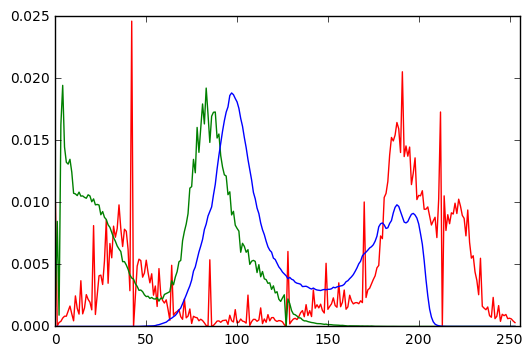

In [8]:
diag=diagnostics.diagnostics(im,image_file,vis_diag=True)


In [9]:
hsv_resize, scale=imtools.imRescaleMaxDim(diag.hsv_corrected,diag.param.middle_size,interpolation = 0)
im_resize, scale=imtools.imRescaleMaxDim(diag.im_corrected,diag.param.middle_size,interpolation = 0)

# SEGMENTATION 1st phase

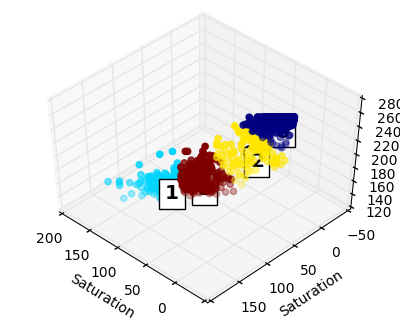

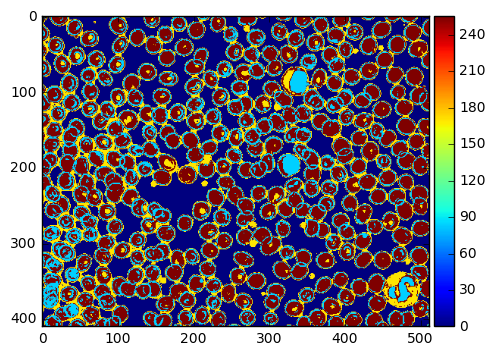

In [10]:
clust_centers_0, label_0 = segmentations.segment_hsv(hsv_resize, init_centers=diag.cent_init,\
                                                    chs=(1,1,2),\
                                                    n_clusters=4,\
                                                    vis_diag=True)   
label_fg_bg=cell_morphology.rbc_labels(im,clust_centers_0,label_0)

# SEGMENTATION 2nd phase

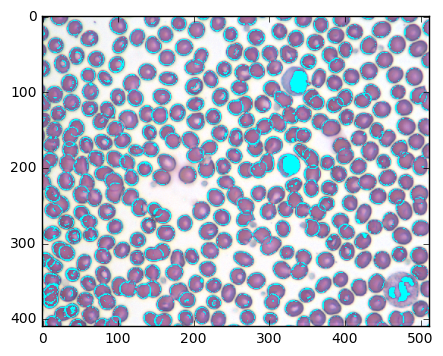

In [11]:
mask_sat=hsv_resize[:,:,1]>diag.sat_q90
wbc_nuc=imtools.overlayImage(im_resize,mask_sat,(0,1,1),1,vis_diag=vis_diag,fig='nuc_mask')


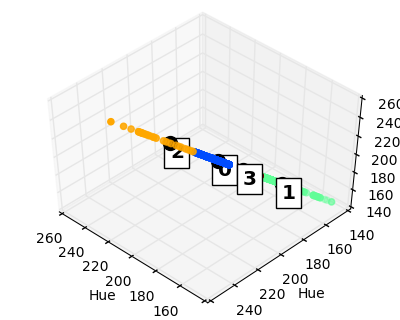

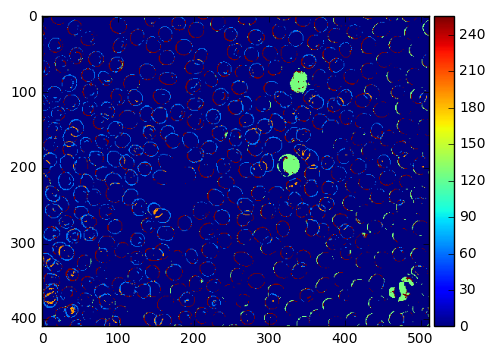

In [12]:
clust_centers_1, label_1 = segmentations.segment_hsv(hsv_resize, mask=mask_sat,\
                                                    cut_channel=1, chs=(0,0,0),\
                                                    n_clusters=4,\
                                                    vis_diag=vis_diag) 

# WBC DETECTION

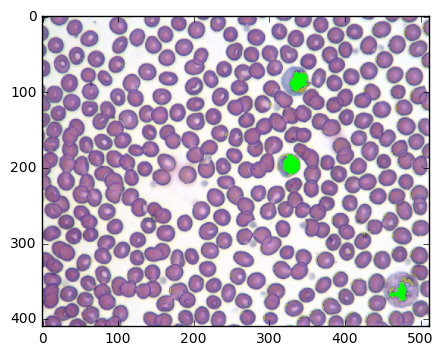

In [13]:
clust_hue=clust_centers_1[:,0]

clust_sat=np.zeros(len(clust_hue))    
mask_wbc=np.zeros(label_1.shape)
label_wbc=np.zeros(label_1.shape)
for i in range(clust_hue.shape[0]):
    hist_hsv=imtools.colorHist(hsv_resize,mask=label_1==i)
    cumh_hsv, siqr_hsv = diag.semi_IQR(hist_hsv) # Semi-Interquartile Range
    clust_sat[i]=np.argwhere(cumh_hsv[1]>0.99)[0,0]
for i in range(clust_hue.shape[0]):
    if clust_sat[i]==clust_sat.max():
        mask_wbc[label_1==i]=1
        mask_temp=label_1==i
        mask_temp=morphology.binary_opening(mask_temp,morphology.disk(np.ceil(scale*diag.param.cell_bound_pct*diag.param.rbcR)))            
        mask_temp=morphology.binary_closing(mask_temp,morphology.disk(np.ceil(0.75*scale*diag.param.rbcR)))            
        label_wbc[mask_temp]=1

wbc_nuc_2=imtools.overlayImage(im_resize,mask_wbc>0,(1,1,0),0.5,vis_diag=False,fig='nuc_mask_2')   
wbc_nuc_2=imtools.overlayImage(wbc_nuc_2,label_wbc>0,(0,1,0),1,vis_diag=vis_diag,fig='nuc_mask_2')
   

# RBC detection

In [14]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")    
    label_fg_bg_orig = img_as_ubyte(resize(label_fg_bg,diag.image_shape, order = 0))
    label_wbc_orig = img_as_ubyte(resize(label_wbc,diag.image_shape, order = 0))
    label_fg_bg_orig[label_wbc_orig>0]=0

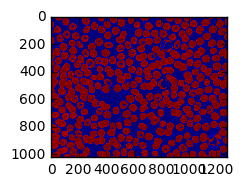

In [15]:

mask_fg_clear=cell_morphology.rbc_mask_morphology(im,label_fg_bg_orig,diag.param,label_tsh=3,vis_diag=vis_diag,fig='31')    
markers_rbc=cell_morphology.rbc_markers_from_mask(mask_fg_clear,diag.param)


# VISUALIZE DETECTIONS

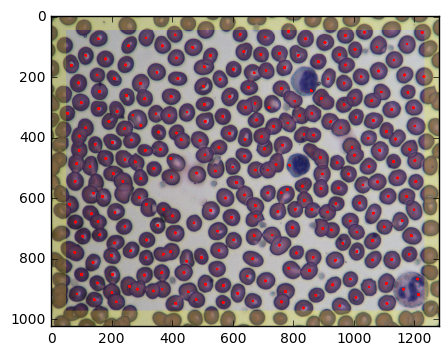

In [20]:
im_detect=imtools.overlayImage(im,morphology.binary_dilation(markers_rbc>0,morphology.disk(5)),\
        (1,0,0),1,vis_diag=False,fig='detections')
border=np.zeros(diag.image_shape).astype('uint8')
border[0:50,:]=1
border[-51:-1,:]=1     
border[:,0:50]=1
border[:,-51:-1]=1    
im_detect=imtools.overlayImage(im_detect,border>0,\
        (1,1,0),0.2,vis_diag=vis_diag,fig='detections')       
im_detect,scale=imtools.imRescaleMaxDim(im_detect,diag.param.middle_size,interpolation = 1)

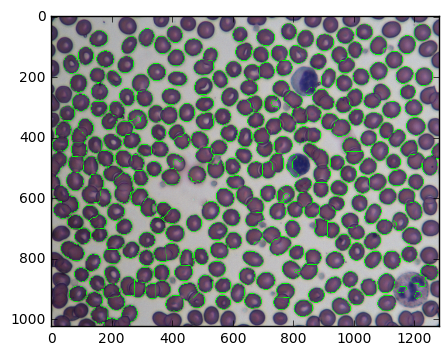

In [21]:
skel, dtf = morphology.medial_axis(mask_fg_clear, return_distance=True)
labels_ws = morphology.watershed(-dtf, markers_rbc, mask=mask_fg_clear)
cell_edges=segmentation.find_boundaries(labels_ws).astype('uint8')*255

im_bound=imtools.overlayImage(im,cell_edges,(0,1,0),1,vis_diag=vis_diag,fig='RBC boundaries')

In [22]:
cnts_RBC = measure.find_contours(markers_rbc>0, 0.5)
cnts_WBC = measure.find_contours(label_wbc_orig>0, 0.5)

shapelist=[]
for c in cnts_RBC:
     c=np.reshape(np.average(c,axis=0),(1,2))
     pts=[]
     for yx in c:
         pts.append((yx[1],yx[0]))
     one_shape=('RBC','point',pts,'None','None')
     shapelist.append(one_shape)
for c in cnts_WBC:
     c=np.reshape(np.average(c,axis=0),(1,2))
     pts=[]
     for yx in c:
         pts.append((yx[1],yx[0]))
     one_shape=('WBC','polygon',pts,'None','None')
     shapelist.append(one_shape)

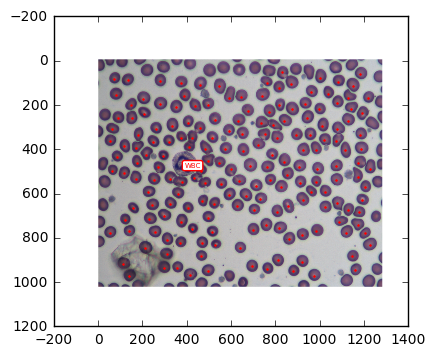

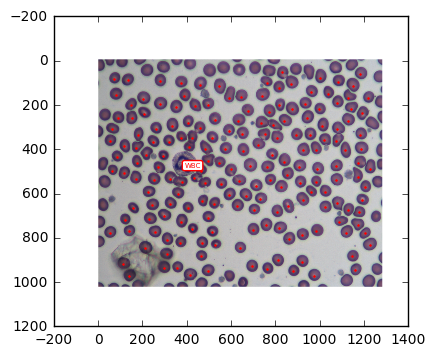

In [26]:
imtools.plotShapes(im,shapelist,detect_shapes='ALL',color='r',text=('WBC'))